In [1]:
import pandas as pd
import numpy as np
import calendar
import itertools
import seaborn as sn
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import glob as glob
import os

In [2]:
df_ = pd.read_csv('../Dados_EDP/anonimized/zKFdRou77JuivhIm.csv')
df_ = df_.rename(columns = {'producao_total':'production_PV','consumo_rede':'consumption','injecao_rede':'grid_injection'})
df_ = df_.drop(['grid_injection'], axis=1)
df_['event_timestamp'] = pd.to_datetime(df_['event_timestamp'], unit='s')
df = df_.sort_values(by=['event_timestamp']).reset_index(drop=True) # Sorting the data by datetime
df.head()

,event_timestamp,consumption,production_PV
0,2019-10-01 00:00:00,0.023,0.0
1,2019-10-01 00:15:00,0.066,0.0
2,2019-10-01 00:30:00,0.050,0.0
3,2019-10-01 00:45:00,0.062,0.0
4,2019-10-01 01:00:00,0.025,0.0


In [3]:
df_sun_pos = pd.read_csv(r'../Dados_EDP/sun_position_PT.csv')
df_sun_pos_ = df_sun_pos.iloc[0:35041,1:] # The sun_position_PT file has 1 more day, so we have to filter it
df = df.join(df_sun_pos_)
df.head()

,event_timestamp,consumption,production_PV,elev,azim
0,2019-10-01 00:00:00,0.023,0.0,-52.66,347.62
1,2019-10-01 00:15:00,0.066,0.0,-53.14,353.78
2,2019-10-01 00:30:00,0.050,0.0,-53.30,0.04
3,2019-10-01 00:45:00,0.062,0.0,-53.14,6.29
4,2019-10-01 01:00:00,0.025,0.0,-52.67,12.45


In [4]:
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=df.index, 
#     y=df['consumption'],
#     mode='markers',  # this will plot dots only. Use 'lines+markers' for lines with dots
#     name='Consumption'
# ))

# fig.update_layout(title='Scatter plot of Consumption',
#                   xaxis_title='Index',
#                   yaxis_title='column_name Value')

# fig.show()

**Outliers**

In [5]:
# def find_outliers_IQR(df):
#     q1 = df.quantile(0.25)
#     q3 = df.quantile(0.75)
#     IQR = q3 - q1
#     outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
#     return outliers.index

In [6]:
# outlier_indices = find_outliers_IQR(df['production_PV'])  # for production_PV column

# # Remove outliers for 'production_PV'
# df_filtered_production = df[~df.index.isin(outlier_indices)]

# outlier_indices = find_outliers_IQR(df['consumption'])  # for consumption column
# # Remove outliers for 'consumption'
# df_filtered_consumption = df[~df.index.isin(outlier_indices)]

# # If you want to remove outliers for both columns simultaneously, you can combine the indices and filter once.
# combined_outlier_indices = set(find_outliers_IQR(df['production_PV'])).union(set(find_outliers_IQR(df['consumption'])))
# df_filtered = df[~df.index.isin(combined_outlier_indices)]
# df_filtered

**Missing Values**

In [7]:
# Missing Values
missing_values = df.isnull().sum()
missing_values

event_timestamp       0
consumption        2138
production_PV      2316
elev                  0
azim                  0
dtype: int64

In [8]:
# Both Missing Values
df_both_nan = df[df['consumption'].isnull() & df['production_PV'].isnull()] # Both nan´s
df_nan = df[df.isna().any(axis=1)] # Nan in each column
display(df_both_nan)
display(df_nan)

,event_timestamp,consumption,production_PV,elev,azim
16033,2020-03-16 00:15:00,NaN,NaN,-51.18,346.50
16773,2020-03-23 17:15:00,NaN,NaN,18.37,256.03
21037,2020-05-07 03:15:00,NaN,NaN,-22.40,41.28
22900,2020-05-26 13:00:00,NaN,NaN,70.93,196.51
23757,2020-06-04 11:15:00,NaN,NaN,65.34,127.97
...,...,...,...,...,...
31166,2020-08-20 15:30:00,NaN,NaN,44.14,244.91
31167,2020-08-20 15:45:00,NaN,NaN,41.49,248.36
31168,2020-08-20 16:00:00,NaN,NaN,38.77,251.59
31169,2020-08-20 16:15:00,NaN,NaN,36.01,254.62


,event_timestamp,consumption,production_PV,elev,azim
129,2019-10-02 08:15:00,0.052,NaN,17.64,110.27
130,2019-10-02 08:30:00,0.000,NaN,20.31,113.04
131,2019-10-02 08:45:00,0.000,NaN,22.93,115.91
132,2019-10-02 09:00:00,0.000,NaN,25.48,118.90
133,2019-10-02 09:15:00,0.000,NaN,27.96,122.04
...,...,...,...,...,...
32236,2020-08-31 19:00:00,0.000,NaN,1.79,279.52
32485,2020-09-03 09:15:00,NaN,NaN,34.15,111.26
32488,2020-09-03 10:00:00,0.016,NaN,41.89,121.47
32489,2020-09-03 10:15:00,NaN,0.101,44.29,125.36


In [9]:
# Interpolate missing values that occur isolated in the dataset

# Creating aux columns
df['nan'] = df['production_PV'].isna()
df['prev_nan'] = df['nan'].shift(fill_value=False)
df['next_nan'] = df['nan'].shift(-1, fill_value=False)

# Criar a mask for isolated nans
mask = df['nan'] & ~df['prev_nan'] & ~df['next_nan']

# Interpolating only where the mask is True
df.loc[mask, 'production_PV'] = df['production_PV'].interpolate(method='linear', limit=1)

# Removing aux columns
df = df.drop(columns=['nan', 'prev_nan', 'next_nan', 'consumption'])

In [10]:
# Creating new columns by splitting the datetime column
df['month'] = df['event_timestamp'].dt.month # Creating a month variable
df['hour'] = df['event_timestamp'].dt.hour # Creating a hour variable
df

,event_timestamp,production_PV,elev,azim,month,hour
0,2019-10-01 00:00:00,0.0,-52.66,347.62,10,0
1,2019-10-01 00:15:00,0.0,-53.14,353.78,10,0
2,2019-10-01 00:30:00,0.0,-53.30,0.04,10,0
3,2019-10-01 00:45:00,0.0,-53.14,6.29,10,0
4,2019-10-01 01:00:00,0.0,-52.67,12.45,10,1
...,...,...,...,...,...,...
35036,2020-09-29 23:00:00,0.0,-47.90,325.23,9,23
35037,2020-09-29 23:15:00,0.0,-49.44,330.40,9,23
35038,2020-09-29 23:30:00,0.0,-50.75,335.88,9,23
35039,2020-09-29 23:45:00,0.0,-51.80,341.63,9,23


In [11]:
# Resampling data hourly
# Exclude June due to absence of data
df_resample_sum = df[['event_timestamp', 'production_PV']].resample('60min', on='event_timestamp').sum()
df_resample_mean = df[['event_timestamp', 'elev', 'azim', 'month', 'hour']].resample('60min', on='event_timestamp').mean()
df_resample = pd.concat([df_resample_sum, df_resample_mean], axis=1)
df_resample = df_resample[df_resample['month']!=6]

df_resample = df_resample.reset_index()
df_resample

,event_timestamp,production_PV,elev,azim,month,hour
0,2019-10-01 00:00:00,0.0,-53.0600,176.9325,10.0,0.0
1,2019-10-01 01:00:00,0.0,-51.2500,21.2025,10.0,1.0
2,2019-10-01 02:00:00,0.0,-45.2200,41.8950,10.0,2.0
3,2019-10-01 03:00:00,0.0,-36.4050,58.0075,10.0,3.0
4,2019-10-01 04:00:00,0.0,-26.0250,70.7175,10.0,4.0
...,...,...,...,...,...,...
8036,2020-09-29 20:00:00,0.0,-23.1475,286.6575,9.0,20.0
8037,2020-09-29 21:00:00,0.0,-33.7900,298.7325,9.0,21.0
8038,2020-09-29 22:00:00,0.0,-43.1000,313.8225,9.0,22.0
8039,2020-09-29 23:00:00,0.0,-49.9725,333.2850,9.0,23.0


In [12]:
# print(df.head(1208))
# print(df_resample.head(24*12+15))
# print(df.head(16100))
# print(df_resample.head(24*31*5+24*12+18))
# print(df.head(14921))
# print(df_resample.head(24*31*5+12))

## Feature Engineering

In [13]:
def feat_eng1(df):
    
    ''' Here I wil create three new variables. The first two will be a simple shift
        of the day before and two days before at the correspondent timestamp,
        and the third will be a feature that makes the average of production_PV
        at each timestamp over the last 7 days'''
    
    # Shiftting values
    one_day = 24
    two_days = 48
    df['production_PV_24h'] = df['production_PV'].shift(one_day)
    df['production_PV_48h'] = df['production_PV'].shift(two_days)
    
    # Creating a Feature that makes the average of production_PV at each timestamp over the last 7 days
    df['7days_mean_PV'] = np.nan
    # creates empty matrix for storing values
    temps = pd.DataFrame([])
    N = 7
    for day in range(1,N+1):
        # reorganizes data for vectorial calculation
        temps['day '+str(day)] = df['production_PV'].shift(one_day*day)
    df['7days_mean_PV'] = temps.mean(axis=1)
    df.loc[0:(N*one_day)-1,'7days_mean_PV'] = np.nan
    
    return df

In [14]:
df_feat1 = feat_eng1(df_resample)

In [15]:
def feat_eng2(df):
    
    ''' Creating two variables, the of PV of day before
        and sum of standard deviation of the day before '''
    
    # Set timestamps as index
    df_1 = df.set_index('event_timestamp')
    # Daily sums
    df_2 = df_1.groupby(pd.Grouper(freq = '1D')).sum().shift(1)
    # Daily averages
    df_3 = df_1.groupby(pd.Grouper(freq = '1D')).mean().shift(1)
    # Daily standard deviations
    df_4 = df_1.groupby(pd.Grouper(freq = '1D')).std().shift(1)

    # New Inputs
    df_1['sum_pv_day_before'] = np.nan
    df_1['std_pv_day_before'] = np.nan

    for doy in range (1,365+1): # doy means day of year

        # -2 refers to 'previous day sum' column
        # -1 refers to 'standard deviation day before' column

        df_1.iloc[(df_1.index.dayofyear == doy),-2] = df_2.iloc[(df_2.index.dayofyear == doy),0][0] 
        df_1.iloc[(df_1.index.dayofyear == doy),-1] = df_4.iloc[(df_4.index.dayofyear == doy),0][0] 

    return df_1

In [16]:
df_feat2 = feat_eng2(df_feat1)

In [17]:
def feat_eng3(df):
    
    ''' Converting the time through sine and cosine in order
        to preserve their cyclical significance'''
    
    # We normalize the hour values to match with the 0-2π cycle
    df["hour_norm"] = 2 * np.pi * df["hour"] / df["hour"].max()
    
    df["cos_hour"] = np.cos(df["hour_norm"])
    df["sin_hour"] = np.sin(df["hour_norm"])

    df = df.drop(['hour', 'hour_norm'], axis=1)
    
    return df

In [18]:
df_feat3 = feat_eng3(df_feat2)
df_feat3.head(10+24*7+24)

,production_PV,elev,azim,month,production_PV_24h,production_PV_48h,7days_mean_PV,sum_pv_day_before,std_pv_day_before,cos_hour,sin_hour
event_timestamp,,,,,,,,,,,
2019-10-01 00:00:00,0.000,-53.0600,176.9325,10.0,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
2019-10-01 01:00:00,0.000,-51.2500,21.2025,10.0,NaN,NaN,NaN,NaN,NaN,0.962917,0.269797
2019-10-01 02:00:00,0.000,-45.2200,41.8950,10.0,NaN,NaN,NaN,NaN,NaN,0.854419,0.519584
2019-10-01 03:00:00,0.000,-36.4050,58.0075,10.0,NaN,NaN,NaN,NaN,NaN,0.682553,0.730836
2019-10-01 04:00:00,0.000,-26.0250,70.7175,10.0,NaN,NaN,NaN,NaN,NaN,0.460065,0.887885
...,...,...,...,...,...,...,...,...,...,...,...
2019-10-09 05:00:00,0.000,-16.3700,84.2800,10.0,0.000,0.000,0.000000,2.472,0.160965,0.203456,0.979084
2019-10-09 06:00:00,0.001,-4.6950,93.9700,10.0,0.001,0.001,0.001143,2.472,0.160965,-0.068242,0.997669
2019-10-09 07:00:00,0.018,6.6450,103.6550,10.0,0.023,0.018,0.019857,2.472,0.160965,-0.334880,0.942261


In [19]:
# def eng_feat3(df):
    
#     ''' Converting the time through sine and cosine in order
#         to preserve their cyclical significance'''
    
#     df['seconds'] = df.index.map(pd.Timestamp.timestamp)

#     day = 60*60*24 # Seconds per day

#     df['day_sin'] = np.sin(df['seconds'] * (2 * np.pi / day))
#     df['day_cos'] = np.cos(df['seconds'] * (2 * np.pi / day))

#     df = df.drop('seconds', axis=1)
    
#     return df

In [20]:
# Just for Visualization
df_feat3.iloc[168:-1,:].head(10)

,production_PV,elev,azim,month,production_PV_24h,production_PV_48h,7days_mean_PV,sum_pv_day_before,std_pv_day_before,cos_hour,sin_hour
event_timestamp,,,,,,,,,,,
2019-10-08 00:00:00,0.000,-55.7625,177.6800,10.0,0.000,0.000,0.000000,2.535,0.168365,1.000000,0.000000
2019-10-08 01:00:00,0.000,-53.6650,23.3225,10.0,0.000,0.000,0.000000,2.535,0.168365,0.962917,0.269797
2019-10-08 02:00:00,0.000,-47.2250,44.6025,10.0,0.000,0.000,0.000000,2.535,0.168365,0.854419,0.519584
2019-10-08 03:00:00,0.000,-38.0700,60.7600,10.0,0.000,0.000,0.000000,2.535,0.168365,0.682553,0.730836
2019-10-08 04:00:00,0.000,-27.4700,73.3450,10.0,0.000,0.000,0.000000,2.535,0.168365,0.460065,0.887885
2019-10-08 05:00:00,0.000,-16.1800,83.9275,10.0,0.000,0.000,0.000000,2.535,0.168365,0.203456,0.979084
2019-10-08 06:00:00,0.001,-4.5125,93.6300,10.0,0.001,0.001,0.001000,2.535,0.168365,-0.068242,0.997669
2019-10-08 07:00:00,0.023,6.8350,103.3175,10.0,0.018,0.010,0.017857,2.535,0.168365,-0.334880,0.942261
2019-10-08 08:00:00,0.038,17.6500,113.7700,10.0,0.051,0.180,0.081000,2.535,0.168365,-0.576680,0.816970


In [44]:
df_feat3.shape

(8041, 11)

In [1]:
range(335-14)

range(0, 321)

In [21]:
def filter_night_out(df, frequency=24, days_lookback=14): # admitting we have 24 records per hour
    
    """This is a dynamic function. The logic here is having a rolling window of 14 days for each record
       which is already resampled hourly.
       First it will loop for each production_PV record, and the ideia is trying to predict what will be
       the production_PV value in the next day based on the last 14 records at each timestamp.
       
       Example: If I want to predict what will be the production_PV value at 1PM in 15 May, this prediction
                will be based on the last 14 records (between 1 and 14 May) at 1PM, then want to predict
                what will be the value at 2PM, this prediction will be based on the values at 2PM between
                1 and 14 May, ... , skipping to the next day, and so on.
       
       Here the night periods are filtered because otherwise the model would have a big bias, predicting that 
       at night the production would be 0, which is obvious, changing the real performance of the model.
       If we are predicting the production_PV values we only want the diurn part of the dataset, that´s why,
       the sun elevation is filtered at 5 degrees and the production_PV values at 0.0001.
    """
    
    df_as_np = df.to_numpy()
    X, y = [], []
    total_days = len(df_as_np) // frequency # Number of days to analyse

    for day in range(total_days - days_lookback):
        for hour in range(frequency):  # For each hour of the day
            start_idx = day * frequency + hour
            end_idx = start_idx + days_lookback * frequency
            
            X_slice = df_as_np[start_idx:end_idx:24]  # Select PV value each day at each timestamp
            
            # Skip the iteration if there is any nan value in X_slice
            if np.isnan(X_slice).any():
                continue
            # Skip the iteration if the sun elevation is <5 and the first value of X_slice is <= 0.0001
            if (X_slice[0][1] < 5) & (X_slice[0][0] < 0.0001):
                continue
            
            y_value = df_as_np[end_idx][0]  # Select PV value of the day after at the same timestamp
            
            non_zero_count = np.count_nonzero(X_slice)  # Count the number of elements non-zero
            
            # Add X_slice if the values are different than 0
            if  not np.all(X_slice == 0):
                X.append(X_slice)
            
            # Condition to decide if we include y_value
            if non_zero_count >= 1:
                y.append(y_value)

    return np.array(X), np.array(y)

In [22]:
X1, y1 = filter_night_out(df_feat3, frequency=24, days_lookback=14)

In [23]:
X1[0]

array([[ 1.00000000e-03, -4.51250000e+00,  9.36300000e+01,
         1.00000000e+01,  1.00000000e-03,  1.00000000e-03,
         1.00000000e-03,  2.53500000e+00,  1.68364979e-01,
        -6.82424134e-02,  9.97668769e-01],
       [ 1.00000000e-03, -4.69500000e+00,  9.39700000e+01,
         1.00000000e+01,  1.00000000e-03,  1.00000000e-03,
         1.14285714e-03,  2.47200000e+00,  1.60965295e-01,
        -6.82424134e-02,  9.97668769e-01],
       [ 1.00000000e-03, -4.92250000e+00,  9.43100000e+01,
         1.00000000e+01,  1.00000000e-03,  1.00000000e-03,
         1.00000000e-03,  3.10400000e+00,  1.88504334e-01,
        -6.82424134e-02,  9.97668769e-01],
       [ 0.00000000e+00, -5.13500000e+00,  9.46450000e+01,
         1.00000000e+01,  1.00000000e-03,  1.00000000e-03,
         1.00000000e-03,  2.88000000e+00,  1.74869890e-01,
        -6.82424134e-02,  9.97668769e-01],
       [ 0.00000000e+00, -5.34000000e+00,  9.49800000e+01,
         1.00000000e+01,  0.00000000e+00,  1.00000000e-03,
  

In [24]:
X1.shape, y1.shape

((3599, 14, 11), (3599,))

In [25]:
X_train, y_train = X1[:2879], y1[:2879]
X_val, y_val = X1[2879:3239], y1[2879:3239]
X_test, y_test = X1[3239:], y1[3239:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2879, 14, 11), (2879,), (360, 14, 11), (360,), (360, 14, 11), (360,))

In [26]:
# def compute_training_stats(X):
#     """
#     Computa a média e o desvio padrão para cada coluna da matriz de treinamento.

#     Args:
#     - X_train (np.array): Array tridimensional com os dados de treinamento.

#     Returns:
#     - training_means (np.array): Médias das colunas da matriz de treinamento.
#     - training_stds (np.array): Desvios padrão das colunas da matriz de treinamento.
#     """
#     means = np.mean(X[:, :, :], axis=(0, 1))
#     stds = np.std(X[:, :, :], axis=(0, 1))
    
#     return means, stds

# def normalize_data(X, means, stds):
#     """
#     Normaliza um conjunto de dados com base em médias e desvios padrão fornecidos.

#     Args:
#     - X (np.array): Array tridimensional com os dados a serem normalizados.
#     - means (np.array): Médias para normalização.
#     - stds (np.array): Desvios padrão para normalização.

#     Returns:
#     - X_normalized (np.array): Dados normalizados.
#     """
#     for i in range(X.shape[2]):
#         X[:, :, i] = (X[:, :, i] - means[i]) / stds[i]
#     return X

In [27]:
# means, stds = compute_training_stats(X_train)
# means, stds = compute_training_stats(X_val)
# means, stds = compute_training_stats(X_test)

In [28]:
# normalize_data(X_train, training_means, training_stds)
# normalize_data(X_val, training_means, training_stds)
# normalize_data(X_test, training_means, training_stds)

In [29]:
# Fit the scaler using only the training data
scaler_X = MinMaxScaler()
X_train_norm = scaler_X.fit_transform(X_train.reshape(X_train.shape[0], -1))  # Fit and transform
X_val_norm = scaler_X.transform(X_val.reshape(X_val.shape[0], -1))
X_test_norm = scaler_X.transform(X_test.reshape(X_test.shape[0], -1))

# Reshape the data back to original shape
X_train_norm = X_train_norm.reshape(X_train.shape)
X_val_norm = X_val_norm.reshape(X_val.shape)
X_test_norm = X_test_norm.reshape(X_test.shape)

# For the target variable
scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_norm = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_norm = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [30]:
print(X_test_norm)
print(X_test_norm.shape)
print(y_test_norm)
print(y_test_norm.shape)

[[[ 0.24825175  0.53050423  0.80928572 ...  0.71913738  0.39193821
    0.02776866]
  [ 0.          0.52781087  0.80852925 ...  0.90785148  0.39193821
    0.02776866]
  [ 0.29370629  0.52514598  0.80779689 ...  0.22576918  0.39193821
    0.02776866]
  ...
  [ 0.24475524  0.50051996  0.80152474 ...  0.9398764   0.39193821
    0.02776866]
  [ 0.          0.49709731  0.80084513 ...  0.97125563  0.39193821
    0.02776866]
  [ 0.23951049  0.49376582  0.80019954 ... -0.01582999  0.39193821
    0.02776866]]

 [[ 0.06818182  0.38784842  0.8528852  ...  0.71913738  0.55129212
    0.        ]
  [ 0.02622378  0.38515081  0.85223576 ...  0.90785148  0.55129212
    0.        ]
  [ 0.08741259  0.38240095  0.85160161 ...  0.22576918  0.55129212
    0.        ]
  ...
  [ 0.0541958   0.35823906  0.84612592 ...  0.9398764   0.55129212
    0.        ]
  [ 0.          0.35550883  0.84554129 ...  0.97125563  0.55129212
    0.        ]
  [ 0.05769231  0.35292647  0.84495069 ... -0.01582999  0.55129212
    0.

In [31]:
model1 = Sequential()
model1.add(InputLayer((14, 11)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19456     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 19985 (78.07 KB)
Trainable params: 19985 (78.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [33]:
model1.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm, y_val_norm), epochs=10, callbacks=[cp1])

Epoch 1/10
90/90 [==============================] - ETA: 0s - loss: 0.0444 - root_mean_squared_error: 0.2108INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


90/90 [==============================] - 20s 157ms/step - loss: 0.0444 - root_mean_squared_error: 0.2108 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1640
Epoch 2/10
88/90 [============================>.] - ETA: 0s - loss: 0.0281 - root_mean_squared_error: 0.1677INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


90/90 [==============================] - 9s 101ms/step - loss: 0.0280 - root_mean_squared_error: 0.1675 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1621
Epoch 3/10
88/90 [============================>.] - ETA: 0s - loss: 0.0274 - root_mean_squared_error: 0.1655INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


90/90 [==============================] - 12s 135ms/step - loss: 0.0275 - root_mean_squared_error: 0.1659 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1620
Epoch 4/10
90/90 [==============================] - 2s 19ms/step - loss: 0.0272 - root_mean_squared_error: 0.1650 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1680
Epoch 5/10
90/90 [==============================] - 2s 19ms/step - loss: 0.0267 - root_mean_squared_error: 0.1633 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1638
Epoch 6/10
90/90 [==============================] - 2s 18ms/step - loss: 0.0266 - root_mean_squared_error: 0.1632 - val_loss: 0.0266 - val_root_mean_squared_error: 0.1632
Epoch 7/10
90/90 [==============================] - 2s 18ms/step - loss: 0.0261 - root_mean_squared_error: 0.1615 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1651
Epoch 8/10
90/90 [==============================] - 2s 18ms/step - loss: 0.0262 - root_mean_squared_error: 0.1620 - val_loss: 0.0268 - val_root_mean_squar

In [34]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [35]:
X_train_forecast = model1.predict(X_train_norm).flatten()
X_train_forecast

90/90 [==============================] - 2s 8ms/step


array([0.01719979, 0.01760004, 0.14028956, ..., 0.25222152, 0.08677325,
       0.01912859], dtype=float32)

In [36]:
train_results = pd.DataFrame(data={'PV_Train_Forecast':X_train_forecast, 'PV_Train_Actuals':y_train_norm})
train_results

,PV_Train_Forecast,PV_Train_Actuals
0,0.017200,0.000000
1,0.017600,0.019231
2,0.140290,0.230769
3,0.315929,0.625874
4,0.446073,0.758741
...,...,...
2874,0.545478,0.601399
2875,0.423351,0.454545
2876,0.252222,0.258741
2877,0.086773,0.082168


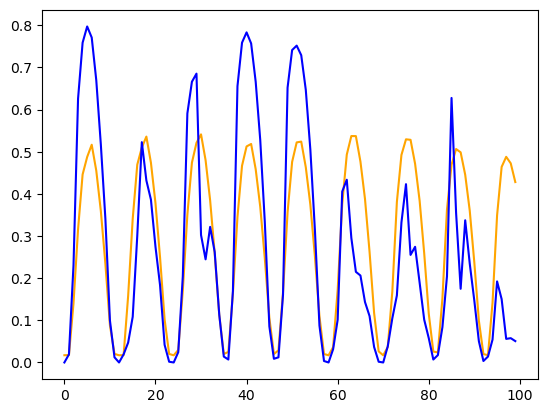

In [37]:
plt.plot(train_results['PV_Train_Forecast'][:100], color='orange')
plt.plot(train_results['PV_Train_Actuals'][:100], color='b')

In [38]:
y_test_predicted_norm = model1.predict(X_test_norm).flatten()
y_test_predicted_norm

12/12 [==============================] - 0s 8ms/step


array([0.1897774 , 0.04081625, 0.01919529, 0.01876913, 0.01703164,
       0.04064076, 0.27937046, 0.49228913, 0.5750942 , 0.6114689 ,
       0.6103569 , 0.5776465 , 0.50714177, 0.373593  , 0.20637968,
       0.05326526, 0.01917571, 0.01703164, 0.04550041, 0.28629282,
       0.5056827 , 0.58750975, 0.621634  , 0.6202705 , 0.58559334,
       0.5142539 , 0.37974563, 0.21176103, 0.05899083, 0.01915988,
       0.01873366, 0.01703164, 0.04164139, 0.2816028 , 0.5086597 ,
       0.59078   , 0.6246865 , 0.62347937, 0.5879643 , 0.5149869 ,
       0.37882236, 0.20840354, 0.05529329, 0.01916176, 0.01874232,
       0.01703164, 0.04331632, 0.28562286, 0.51741433, 0.5976857 ,
       0.6303855 , 0.6287097 , 0.5930035 , 0.52090764, 0.38444737,
       0.21162285, 0.05689169, 0.01914706, 0.01873502, 0.01703164,
       0.04540423, 0.28633788, 0.5223942 , 0.60087097, 0.6324656 ,
       0.63024926, 0.5950309 , 0.5224582 , 0.38686422, 0.2129637 ,
       0.05870253, 0.01911824, 0.01871251, 0.01703164, 0.04553

In [39]:
y_test_predicted_original_scale = scaler_y.inverse_transform(y_test_predicted_norm.reshape(-1, 1)).flatten()
y_test_actual_original_scale = scaler_y.inverse_transform(y_test_norm.reshape(-1, 1)).flatten()

In [40]:
test_results = pd.DataFrame(data={'PV_Test_Forecast':y_test_predicted_original_scale, 'PV_Test_Actuals':y_test_actual_original_scale})
test_results

,PV_Test_Forecast,PV_Test_Actuals
0,0.108553,0.128
1,0.023347,0.032
2,0.010980,0.009
3,0.010736,0.000
4,0.009742,0.002
...,...,...
355,0.253269,0.302
356,0.191001,0.203
357,0.098224,0.092
358,0.029096,0.023


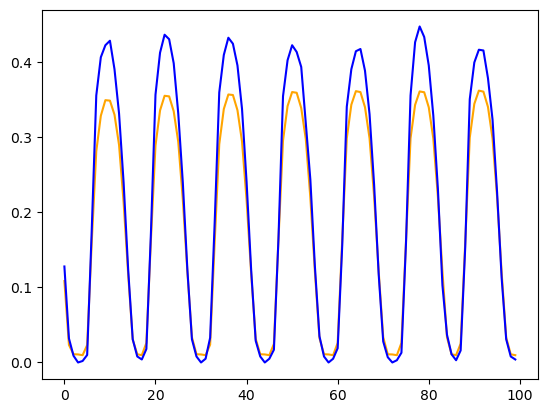

In [42]:
plt.plot(test_results['PV_Test_Forecast'][:100], color='orange')
plt.plot(test_results['PV_Test_Actuals'][:100], color='b')

In [56]:
# # Suponhamos que X_test_norm tenha o formato (n_samples, n_time_steps, n_features)

# # Reshape para 2D
# X_test_norm_2d = X_test_norm.reshape(-1, X_test_norm.shape[1]*X_test_norm.shape[2])

# # # Verifique a forma após a remodelação
# print(X_test_norm_2d.shape)
# print('\n')

# # Certifique-se de que o número de características corresponda ao esperado pelo scaler
# assert X_test_norm_2d.shape[1] == len(scaler_X.scale_)

# # Inverte a transformação
# X_predicted_original_scale_2d = scaler_X.inverse_transform(X_test_norm_2d)

# # Remodela de volta para a forma original
# X_predicted_original_scale = X_predicted_original_scale_2d.reshape(X_test_norm.shape[0], X_test_norm.shape[1], X_test_norm.shape[2])
# X_predicted_original_scale = X_predicted_original_scale[:,0,0]
# print(X_predicted_original_scale.shape)


# print('\n')
# # Remodela de volta para a forma original
# y_predicted_original_scale = scaler_y.inverse_transform(y_test_norm.reshape(-1, 1)).flatten()
# print(y_predicted_original_scale)
# print(y_predicted_original_scale.shape)

In [ ]:
# X_predicted_original_scale = scaler_X.inverse_transform(X_test_norm.reshape(-1, 1)).flatten()
# print(X_predicted_original_scale)
# y_predicted_original_scale = scaler_y.inverse_transform(y_test_norm.reshape(-1, 1)).flatten()
# print(y_predicted_original_scale)

In [ ]:
# def data_normalization(X_train, X_val, X_test, y_train, y_val, y_test):
    
#     # Fit the scaler using only the training data
#     scaler_X = MinMaxScaler()
#     X_train_norm = scaler_X.fit_transform(X_train.reshape(X_train.shape[0], -1))  # Fit and transform
#     X_val_norm = scaler_X.transform(X_val.reshape(X_val.shape[0], -1))
#     X_test_norm = scaler_X.transform(X_test.reshape(X_test.shape[0], -1))

#     # Reshape the data back to original shape
#     X_train_norm = X_train_norm.reshape(X_train.shape)
#     X_val_norm = X_val_norm.reshape(X_val.shape)
#     X_test_norm = X_test_norm.reshape(X_test.shape)

#     # For the target variable
#     scaler_y = MinMaxScaler()
#     y_train_norm = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
#     y_val_norm = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
#     y_test_norm = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
#     return X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_norm

In [ ]:
# X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_n = data_normalization(X_train, X_val, X_test, y_train, y_val, y_test)
# X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_n

In [ ]:
df_feat = df_feat.set_index(['event_timestamp'])

# Substitui valores infinitos por NaN
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

from sklearn.preprocessing import MinMaxScaler

# Identifique colunas do tipo float
cols_to_scale = df_feat.select_dtypes(include=['float64']).columns

# Inicialize e aplique o MinMaxScaler
scaler = MinMaxScaler()
df_feat[cols_to_scale] = scaler.fit_transform(df_feat[cols_to_scale])

df_feat  # Mostrar as primeiras linhas para verificar as transformações

In [ ]:
# def filter_night_out2(df, frequency=24, days_lookback=14):  # Admitting we have 24 records a day
#     df_as_np = df.to_numpy()
#     X, y = [], []
#     total_days = len(df_as_np) // frequency

#     for day in range(total_days - days_lookback):
#         for hour in range(frequency):  # For each hour of the day
#             start_idx = day * frequency + hour
#             end_idx = start_idx + days_lookback * frequency

#             X_slice = df_as_np[start_idx:end_idx:frequency]  # Select all columns each day for a specific timestamp

# #             # Filtering out slices that contain 1 or more NaNs
# #             if np.any(np.isnan(X_slice)):
# #                 continue  # Skip this slice if there's a NaN

#             non_zero_count = np.count_nonzero(X_slice)  # Count the number of elements non-zero

#             if non_zero_count > 0:  # Include only if there are non-zero values in X_slice
#                 X.append(X_slice)
#                 y_value = df_as_np[end_idx][0]  # Select the value of the day after at the same timestamp
#                 y.append(y_value)

#     return np.array(X), np.array(y)

In [ ]:
# df_feat = df_feat.set_index(['event_timestamp'])

# # Substitui valores infinitos por NaN
# df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

# from sklearn.preprocessing import MinMaxScaler

# # Identifique colunas do tipo float
# cols_to_scale = df_feat.select_dtypes(include=['float64']).columns

# # Inicialize e aplique o MinMaxScaler
# scaler = MinMaxScaler()
# df_feat[cols_to_scale] = scaler.fit_transform(df_feat[cols_to_scale])

# df_feat  # Mostrar as primeiras linhas para verificar as transformações

In [ ]:
# def filter_night_out(df, train_weeks=8, test_weeks=2):
#     train_test_splits = []    
    
#     hours_per_week = 24 * 7
#     train_duration = hours_per_week * train_weeks
#     test_duration = hours_per_week * test_weeks

#     # O início do conjunto de treino começa na primeira entrada do dataset
#     start_train = 0
#     end_train = train_duration

#     # O início do conjunto de teste começa após o conjunto de treino
#     start_test = end_train
#     end_test = start_test + test_duration
    
#     # Enquanto houver dados suficientes para formar um novo conjunto de teste
#     while end_test <= len(df):
#         train = df.iloc[start_train:end_train]
#         test = df.iloc[start_test:end_test]
        
#         train_test_splits.append((train, test))
        
#         # Move o ponto de partida do conjunto de treino e teste para a próxima iteração
#         start_train += hours_per_week
#         end_train = start_train + train_duration
#         start_test = end_train
#         end_test = start_test + test_duration

#     return train_test_splits

In [ ]:
# # Por exemplo, para acessar o primeiro conjunto de treino: splits[0][0]
# # E para acessar o primeiro conjunto de teste: splits[0][1]

# filter_night_out(df_feat)